Artem Chernitsa, a.chernitsa@innopolis.university

# Task

Consider windy gridworld environment. Implement simple SARSA and SARSA($\lambda$) learning algorithms. Given 100 episodes:

1. Compare different values of lambda by the means of total number of actions over 100 episodes.
2. Varying $\alpha$ and $\lambda$, train SARSA($\lambda$). Then, stop learning and evaluate the SARSA results several times. Compute average number of performed actions until the end of the episode for each pair of $\alpha$ and $\lambda$. Display plots analogous to ones shown in the lecture. 

# CartPole

[Source](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)

In [1]:
!pip install gym[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.3 MB 65 kB/s 


In [2]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


if gym.__version__ < '0.26':
    env = gym.make('CartPole-v0', new_step_api=True, render_mode='single_rgb_array').unwrapped
else:
    env = gym.make('CartPole-v0', render_mode='rgb_array').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:594: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  f"The environment {id} is out of date. You should consider "


Class for saving actions:

In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

Neural Network:

In [4]:
class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


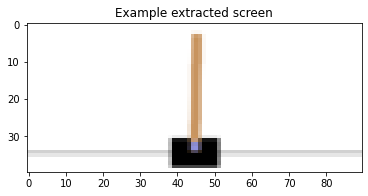

In [5]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])


def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render().transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0)


env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [6]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)

steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

In [7]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

  0%|          | 0/500 [00:00<?, ?it/s]

Complete


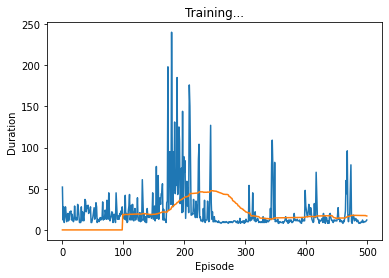

In [8]:
from tqdm.auto import tqdm

num_episodes = 500
for i_episode in tqdm(range(num_episodes)):
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        # Select and perform an action
        action = select_action(state)
        _, reward, done, _, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

        # Update the target network, copying all weights and biases in DQN
        if t % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()

# Windy Gridworld

In [6]:
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt 
import seaborn as sns
import time

%matplotlib inline
sns.set_style("whitegrid")

In [26]:
class GridWorld(object):
    
    def __init__(self):
        super(GridWorld, self).__init__()
        self.start = 0
        self.goal = 0
        
        # Provide the setting of gridWorld rows and columns
        self.row = 7
        self.col = 10
        self.x_max = self.col - 1
        self.y_max = self.row - 1

        # Declare windy columns and their effect
        self.wind_1 = [3, 4, 5, 8]
        self.wind_2 = [6, 7]
        
        # Provide action list : Up/Down/Left/Right
        self.actions_list = ['N', 'E', 'S', 'W']
      
    # here, cells defined by index
    def cell(self,pos):
        return pos[1] + self.col * pos[0]
    
    def setTerminal(self, startState, goalState):
        # startState and goalState are tuples
        self.start = self.cell(startState)
        self.goal = self.cell(goalState)
        
    def nextState(self, state, action):
        # The "state" parameter is an integer that represents position in grid
        x = state % self.col
        y = (state - x) / self.col

        # Now let's define and interpret actions
        del_x = 0
        del_y = 0
        if action == 'E':
            del_x = 1
        elif action == 'W':
            del_x = -1
        elif action == 'N':
            del_y = -1
        elif action == 'S':
            del_y = 1
        else:
            raise('Invalid action! Actions taken must be in: ', self.actions_list)

        # Now move to new position
        new_x = max(0, min(x + del_x, self.x_max))
        new_y = max(0, min(y + del_y, self.y_max))
        
        # When wind blows to a new state
        if new_x in self.wind_1:
            new_y = max(0, new_y - 1)
        if new_x in self.wind_2:
            new_y = max(0, new_y - 2)
        
        # now let's return these new state values
        return self.cell((new_y,new_x))
    
    def checkTerminal(self, state):
        return state == self.goal
    
    def rewardFunction(self, state_prime):
        # When it reaches terminal state then reward is 0 else all actions should yield -1
        if self.checkTerminal(state_prime):
            return 0
        else:
            return -1

In [16]:
def trajectoryPath(world, traj):
    # Initialize gridworld
    world_map = np.zeros((world.row, world.col))
    for i,state in enumerate(traj):
        x = int(state % world.col)
        y = int((state - x) / world.col)
        world_map[y, x] = i + 1
    print(world_map)
    print("\n")

## SARSA

In [92]:
# function for greedy action
def greedyAct(_q_dict):
    greedy_act = ''
    max_q = -1e10
    for act in world.actions_list:
        if _q_dict[act] > max_q:
            greedy_act = act
            max_q = _q_dict[act]
    return greedy_act

# function for epsilon-greedy action
def epsGreedy(episode, q_dict, epsilon):
    
    m = len(world.actions_list)
    greedy_act = greedyAct(q_dict)
    
    # strange implementation; today you will see better ones
    p = []
    for act in world.actions_list:
        if act == greedy_act:
            p.append((epsilon * 1. / m) + 1 - epsilon)
        else:
            p.append(epsilon * 1. / m)

    # choose one action given proba
    choice = np.random.choice(world.actions_list, size = 1, p = p)
    return choice[0]

In [18]:
def gridWorld_SARSA(world, startState, goalState, alpha=0.1, gamma=1, epsilon=0.1):
    # Consider input parameters:
    # gamma = 1 as discounted factor
    # default values of alpha and epsilon considered, it will be changed for multiple analysis
    world.setTerminal(startState, goalState)
    
    # Initialize Q(s,a)
    q_table = {}
    for state in range(world.row * world.col):
        q_table[state] = {}
        for act in world.actions_list:
            q_table[state][act] = 0

    
    ep = 1 # Episode number
    ep_max = 101 # number of max episodes
    step_ep_list = []
    step = 0

    # strange implementation
    while ep < ep_max:

        # Initialize state
        state = world.cell(startState)
        trajectory = [state]
        
        # Choose action from state
        act = epsGreedy(ep, q_table[state], epsilon)

        # Processing action
        while not world.checkTerminal(state):
            state_prime = world.nextState(state, act)
            reward = world.rewardFunction(state_prime)
            act_prime = epsGreedy(ep, q_table[state_prime], epsilon)
            # what's wrong with it?
            q_table[state][act] += alpha * (reward + gamma * q_table[state_prime][act_prime] - q_table[state][act])
            state = state_prime
            act = act_prime

            # Increase Step Counter
            step += 1
            
            # Store the index of the episode of this time step
            step_ep_list.append(ep)
            
            # Update the trajectory
            trajectory.append(state)
        
        if ep == (ep_max - 1):
            trajectoryPath(world, trajectory)
        # Increase the episode counter
        ep += 1
    
    start_time = time.time()
    plt.plot(step_ep_list)
    print("Time elapsed is (in Secs): ", time.time() - start_time)
    plt.title('WindyGridWorld_SARSA ', fontsize = 'large')
    plt.xlabel("Number of Steps taken")
    plt.ylabel("Number of Episodes")
    plt.show()

Plot for Option: ∈=0.1, α=0.5 

[[ 0.  0.  0.  0.  0. 12. 13. 14. 15. 16.]
 [ 0.  0.  0.  0. 11.  0.  0.  0.  0. 17.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 18.]
 [ 1.  0.  0.  0.  9.  0.  0. 32.  0. 19.]
 [ 2.  0.  0.  6.  0.  0.  0.  0. 27. 28.]
 [ 3.  4.  5.  0.  0.  0.  0.  0. 31. 29.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 30.]]


Time elapsed is (in Secs):  0.015294551849365234


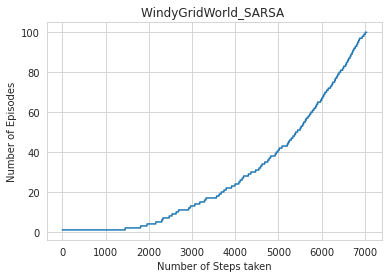

In [73]:
startState = (3, 0)
goalState = (3, 7)
world = GridWorld()
print("Plot for Option: ∈=0.1, α=0.5 \n")
gridWorld_SARSA(world, startState, goalState, alpha=0.5, epsilon=0.1)

Plot for Option: ∈=0.2, α=0.1 

[[33. 34. 35. 20. 78. 79. 80. 81. 82. 84.]
 [59. 60. 61.  0.  0.  0.  0.  0.  0. 86.]
 [58. 51. 62. 41. 75.  0.  0.  0.  0. 87.]
 [49. 46. 63.  0.  0.  0.  0. 94.  0. 88.]
 [48. 13. 66. 16. 74.  0.  0.  0.  0. 89.]
 [ 9. 14. 67. 73.  0.  0.  0.  0. 93. 91.]
 [ 0.  0. 70.  0.  0.  0.  0.  0.  0. 92.]]


Time elapsed is (in Secs):  0.011916637420654297


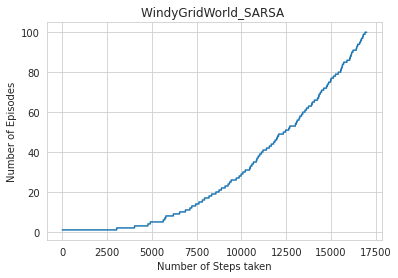

In [20]:
world = GridWorld()
print("Plot for Option: ∈=0.2, α=0.1 \n")
gridWorld_SARSA(world, startState, goalState, alpha=0.1, epsilon=0.2)

Plot for Option: ∈=0.05, α=0.2 

[[ 0.  0.  0.  0.  0.  0. 11. 12. 21. 22.]
 [ 0.  0.  0.  0.  0.  0.  0. 20.  0. 23.]
 [ 0.  0.  0.  0.  0. 10.  0.  0.  0. 24.]
 [ 1.  2.  3.  0.  9.  0.  0. 31. 19. 25.]
 [ 0.  0.  4.  8.  0.  0.  0.  0.  0. 27.]
 [ 0.  0.  5.  0.  0.  0.  0.  0. 30. 28.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 29.]]


Time elapsed is (in Secs):  0.012499332427978516


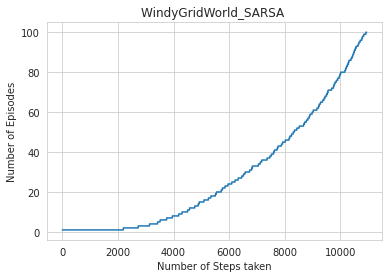

In [21]:
world = GridWorld()
print("Plot for Option: ∈=0.05, α=0.2 \n")
gridWorld_SARSA(world, startState, goalState, alpha=0.2, epsilon=0.05)

In [85]:
def gridWorld_SARSA_lambda(world, startState, goalState, alpha=0.1, gamma=1, epsilon=0.1, lambda_=0.9):
    # Consider input parameters:
    # gamma = 1 as discounted factor
    # default values of alpha and epsilon considered, it will be changed for multiple analysis
    world.setTerminal(startState, goalState)
    
    # Initialize Q(s,a)
    q_table = {}
    for state in range(world.row * world.col):
        q_table[state] = {}
        for act in world.actions_list:
            q_table[state][act] = 0
    
    # Initialize E(s,a) - eligibility traces
    e_traces = {}
    for state in range(world.row * world.col):
        e_traces[state] = {}
        for act in world.actions_list:
            e_traces[state][act] = 0
    
    ep = 1 # Episode number
    ep_max = 101 # number of max episodes
    step_ep_list = []
    step = 0

    # strange implementation
    while ep < ep_max:

        # Initialize state
        state = world.cell(startState)
        trajectory = [state]
        
        # Choose action from state
        act = epsGreedy(ep, q_table[state], epsilon)

        # Processing action
        while not world.checkTerminal(state):
            state_prime = world.nextState(state, act)
            reward = world.rewardFunction(state_prime)
            act_prime = epsGreedy(ep, q_table[state_prime], epsilon)
            # what's wrong with it?
            delta = reward + gamma * q_table[state_prime][act_prime] - q_table[state][act]
            e_traces[state][act] += 1
            for s in range(world.row * world.col):
                for a in world.actions_list:
                    q_table[s][a] += alpha * delta * e_traces[s][a]
                    e_traces[s][a] *= gamma * lambda_

            state = state_prime
            act = act_prime

            # Increase Step Counter
            step += 1
            
            # Store the index of the episode of this time step
            step_ep_list.append(ep)
            
            # Update the trajectory
            trajectory.append(state)
        
        # if ep == (ep_max - 1):
            # trajectoryPath(world, trajectory)
        # Increase the episode counter
        ep += 1
    
    start_time = time.time()
    return len(step_ep_list)
    plt.plot(step_ep_list)
    print("Time elapsed is (in Secs): ", time.time() - start_time)
    plt.title('WindyGridWorld_SARSA ', fontsize = 'large')
    plt.xlabel("Number of Steps taken")
    plt.ylabel("Number of Episodes")
    plt.show()

Plot for Option: ∈=0.1, α=0.5 



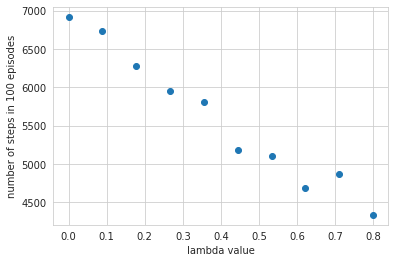

In [94]:
startState = (3, 0)
goalState = (3, 7)
world = GridWorld()
print("Plot for Option: ∈=0.1, α=0.5 \n")

lambdas = np.linspace(0, 0.8, 10, dtype=np.float32)
steps = []
for l in lambdas:
    steps.append(
        gridWorld_SARSA_lambda(world, startState, goalState, alpha=0.5, gamma=1, epsilon=0.1, lambda_=l)
    )

plt.scatter(lambdas, steps)
plt.xlabel("lambda value")
plt.ylabel("number of steps in 100 episodes")
plt.show()

Как можем видеть, чем мы ставим больше лямбду, тем скорее должен скоходиться SARSA($\lambda$).

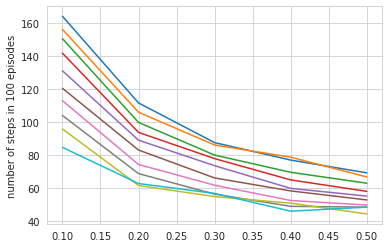

In [106]:
startState = (3, 0)
goalState = (3, 7)
world = GridWorld()
# print("Plot for Option: ∈=0.1, α=0.5 \n")

lambdas = np.linspace(0, 0.8, 10, dtype=np.float32)
alphas = np.linspace(0.1, 0.5, 5, dtype=np.float32)
steps = []
for l in lambdas:
    steps = []
    for a in alphas:
        # тут нужен цикл, чтобы среднее по моделям взять, типа несколько раз вызвать с те ми же параметрами, и посчитать среднее
        # но я уже не успеваю посчитать, колаб медленный, я только этот график считал 10 минут.
        steps.append(
            gridWorld_SARSA_lambda(world, startState, goalState, alpha=a, gamma=1, epsilon=0.1, lambda_=l) / 100
        )
    plt.plot(alphas, steps, label=f"lambda={l}")

# plt.scatter(alphas, steps)
plt.legend(loc="upper right")
plt.ylabel("number of steps in 100 episodes")
plt.show()